# APPLE STOCKS PREDICTING WITH LSTM

# Importing modules

In [1]:
# Math
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Datasets
import yfinance as yf

# Machine learning
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Loading data

In [2]:
# Loading data
original_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')

[*********************100%***********************]  1 of 1 completed


# Exploring data

In [3]:
# Presenting data
display(original_data.head(5))

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.074736,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.471441,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.012121,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.040895,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.157442,283192000


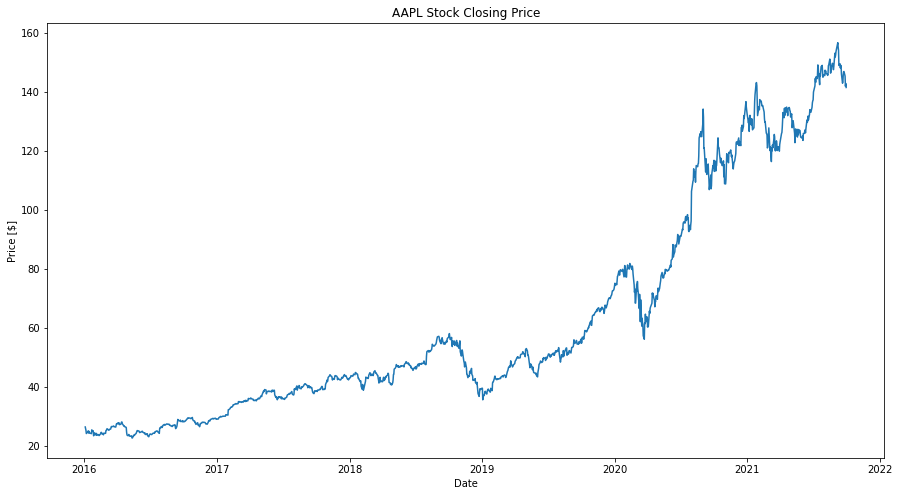

In [4]:
# Plotting data
plt.figure(figsize=(15, 8))
plt.title('AAPL Stock Closing Price')
plt.plot(original_data['Close'])
plt.xlabel('Date')
plt.ylabel('Price [$]')
plt.show()

# Preparing data

In [5]:
# Defining variables
close_prices = original_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

# Scaling to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

In [6]:
# Preparing training data
train_data = scaled_data[0: training_data_len, :]
X_train = [] # (1098, 60, 1) Will contain slices of 60 values
y_train = [] # (1098,1) Will contain the values following the training time series - the 61st value
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# Preparing testing data
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Defining model

In [8]:
# Defining model
model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1], 1)),
    layers.LSTM(100, return_sequences=True),
    layers.LSTM(100, return_sequences=False),
    layers.Dense(25),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


# Training

In [9]:
# Training model
model.fit(X_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1098/1098 [==============================] - 37s 28ms/step - loss: 0.0010
Epoch 2/3
1098/1098 [==============================] - 29s 26ms/step - loss: 4.8449e-04
Epoch 3/3
1098/1098 [==============================] - 30s 27ms/step - loss: 2.9548e-04


# Predicting

In [10]:
# Predicting
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 1s 18ms/step


# Evaluating predictions

<ipython-input-11-fda89714785b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


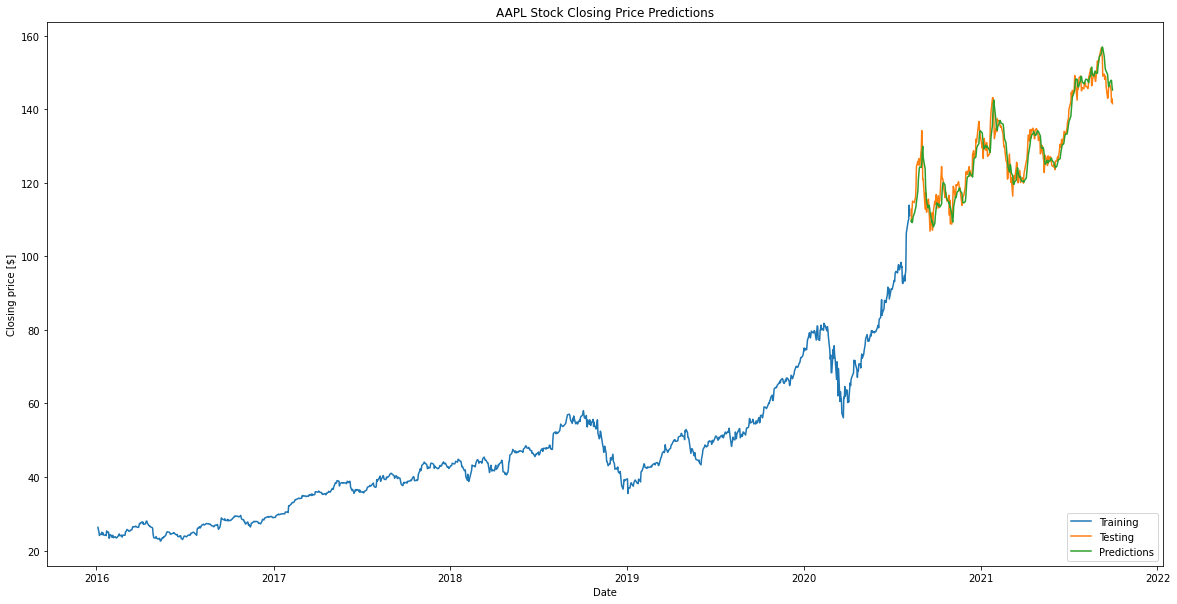

In [11]:
# Defining variables
data_closing = original_data.filter(['Close'])
train = data_closing[:training_data_len]
test = data_closing[training_data_len:]
test['Predictions'] = predictions

# Plotting predictions
plt.figure(figsize=(20,10))
plt.plot(train)
plt.plot(test[['Close', 'Predictions']])
plt.title('AAPL Stock Closing Price Predictions')
plt.xlabel('Date')
plt.ylabel('Closing price [$]')
plt.legend(['Training', 'Testing', 'Predictions'], loc='lower right')
plt.show()

In [12]:
# Calculating evaluation metrics
mae = np.mean(np.abs(predictions - y_test))
print('MAE =', mae)

rmse = np.sqrt(np.mean((predictions - y_test)**2))
print('RMSE =', rmse)

MAE = 13.84845237527773
RMSE = 17.193895838416786
